In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [2]:
merge_on = ['mlp_ratio', 'num_heads', 'embed_dim', 'layer_num']

# add msa and mlp scores
def add_decomp(folder, data, ind, com):
    if ind  in ['dss', 'synflow', 'logsynflow']:
        ind_com = pd.read_csv(os.path.join(folder, 'test/search_results_'+ind+'_'+com+'_nolinear.csv')).rename(columns={ind:ind+'_'+com})
    else:
        ind_com = pd.read_csv(os.path.join(folder, 'test/search_results_'+ind+'_'+com+'.csv')).rename(columns={ind:ind+'_'+com})
    data = pd.merge(data, ind_com[['mlp_ratio', 'num_heads', 'embed_dim', 'layer_num', ind+'_'+com]], on=merge_on)
    return data

def add_ind_new(folder, data, ind):
    ind_com = pd.read_csv(os.path.join(folder, 'test/search_results_'+ind+'_origin_nolinear.csv')).rename(columns={ind:ind+'_no_Sn'})
    data = pd.merge(data, ind_com[['mlp_ratio', 'num_heads', 'embed_dim', 'layer_num', ind+'_no_Sn']], on=merge_on)
    return data

def add_head_mlp_dim(data):
    if 'embed_dim_s' not in data.columns:
        tmp_embed_dim = data['embed_dim'].apply(eval).tolist()
        data['embed_dim_s'] = [np.unique(i).tolist()[0] for i in tmp_embed_dim]
        
    data['num_heads_l'] = data['num_heads'].apply(eval).tolist()
    data['embed_dim_l'] = data['embed_dim'].apply(eval).tolist()
    data['head_dim'] = [np.array(data.iloc[i]['embed_dim_l']) // np.array(data.iloc[i]['num_heads_l']) for i in range(len(data))]
    data['mean_head_dim'] = [np.mean(data.iloc[i]['head_dim']) for i in range(len(data))]
    data['sum_head_dim'] = [np.sum(data.iloc[i]['head_dim']) for i in range(len(data))]
    
    data['mlp_ratio_l'] = data['mlp_ratio'].apply(eval).tolist()
    data['mean_mlp_dim'] = [np.mean(data.iloc[i]['mlp_ratio_l'])*data.iloc[i]['embed_dim_s'] for i in range(len(data))]
    data['sum_mlp_dim'] = [np.sum(data.iloc[i]['mlp_ratio_l'])*data.iloc[i]['embed_dim_s'] for i in range(len(data))]
    
    data['mean_num_heads'] = [np.mean(data.iloc[i]['num_heads_l']) for i in range(len(data))]
    data['mean_mlp_ratio'] = [np.mean(data.iloc[i]['mlp_ratio_l']) for i in range(len(data))]
    data['sum_num_heads'] = [np.sum(data.iloc[i]['num_heads_l']) for i in range(len(data))]
    data['sum_mlp_ratio'] = [np.sum(data.iloc[i]['mlp_ratio_l']) for i in range(len(data))]
    
    data = data.drop(columns=['num_heads_l', 'embed_dim_l', 'mlp_ratio_l'])
    return data

def get_corrs_factors(data, inds, factor):
    corrs = []
    if factor == 'embed_dim':
        factor = 'embed_dim_s'
    for ind in inds:
        if ind == 'Oracle_OA':
            corrs.append(round(stats.spearmanr(data['OA'], data[factor])[0], 4))
        else:
            corrs.append(round(stats.spearmanr(data[ind], data[factor])[0], 4))
    return corrs

def corr_space_ind(data, ind):
    sns.set(style='ticks')
    fig, ax = plt.subplots(2,2, figsize=(12,9), facecolor='white')
    
    if 'embed_dim_s' not in data.columns:
        tmp_embed_dim = data['embed_dim'].apply(eval).tolist()
        data['embed_dim_s'] = [np.unique(i).tolist()[0] for i in tmp_embed_dim]
    
    layernum = pd.DataFrame({ind: data[ind].to_list(), 'layer_num': [int(v) for v in data['layer_num']]})
    corrs_layernum = stats.spearmanr(layernum[ind], layernum['layer_num'])
    sns.scatterplot(data=layernum, x='layer_num', y=ind, ax=ax[0][0])
    ax[0][0].set_title(ind + ' with layer_num \n Spearman correlation: {:.4f} \n p value: {}'.format(corrs_layernum[0], corrs_layernum[1]))
    ax[0][0].grid()

    embeddim = pd.DataFrame({ind: data[ind].to_list(), 'embed_dim': data['embed_dim_s']})
    corrs_emb = stats.spearmanr(embeddim[ind], embeddim['embed_dim'])
    sns.scatterplot(data=embeddim, x='embed_dim', y=ind, ax=ax[0][1])
    ax[0][1].set_title(ind + ' with embed_dim \n Spearman correlation: {:.4f} \n p value: {}'.format(corrs_emb[0], corrs_emb[1]))
    ax[0][1].grid()

    corrs_numheads = stats.spearmanr(data[ind], data['num_heads'])
    sns.scatterplot(data=data[[ind,'num_heads']], x='num_heads', y=ind, ax=ax[1][0])
    ax[1][0].set_title(ind + ' with num_heads \n Spearman correlation: {:.4f} \n p value: {}'.format(corrs_numheads[0], corrs_numheads[1]))
    ax[1][0].grid()
    ax[1][0].xaxis.set_major_locator(plt.NullLocator())

    corrs_mlpratio = stats.spearmanr(data[ind], data['mlp_ratio'])
    sns.scatterplot(data=data[[ind,'mlp_ratio']], x='mlp_ratio', y=ind, ax=ax[1][1])
    ax[1][1].set_title(ind + ' with mlp_ratio \n Spearman correlation: {:.4f} \n p value: {}'.format(corrs_mlpratio[0], corrs_mlpratio[1]))
    ax[1][1].grid()
    ax[1][1].xaxis.set_major_locator(plt.NullLocator())

    fig.tight_layout(pad=2.0)
    plt.show()

def corr_single_ind(data, num, ind):
    corrs = stats.spearmanr(data[ind], data['OA'])
    sns.scatterplot(data=data[[ind, 'OA']], y='OA', x=ind)
    plt.title(ind + ': ' + str(num)+ ' subnets and retrain 300 epochs/net \n Spearman correlation: {:.4f} \n p value: {}'.format(corrs[0], corrs[1]))
    plt.grid()
    plt.show()
def plot_result_single(data, ind):
    corr_single_ind(data, len(data), ind)
    print(data[data[ind] == max(data[ind])][['OA', 'm_size']].iloc[0]) 

In [3]:
indian = pd.read_csv('./results/indian_2000_new_all.csv')
houston = pd.read_csv('./results/houston_2000_new_all.csv')
pavia = pd.read_csv('./results/pavia_2000_new_all.csv')
ksc = pd.read_csv('./results/ksc_2000_new_all.csv')
salinas = pd.read_csv('./results/salinas_2000_new_all.csv')

indian = add_head_mlp_dim(indian)
houston = add_head_mlp_dim(houston)
pavia = add_head_mlp_dim(pavia)
ksc = add_head_mlp_dim(ksc)
salinas = add_head_mlp_dim(salinas)

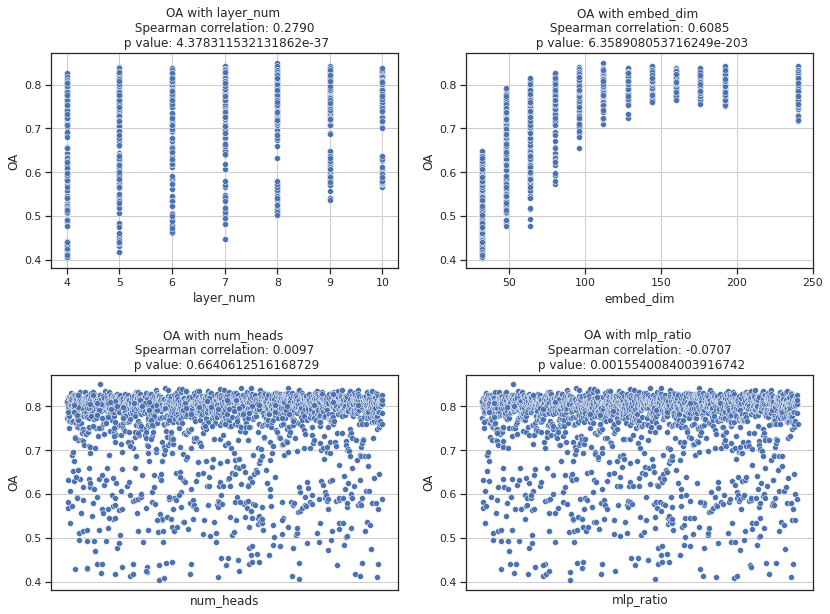

In [4]:
corr_space_ind(indian, 'OA')

In [5]:
## add scores without sign
indian = add_ind_new('./outputs/indian/', indian, 'synflow')
indian = add_ind_new('./outputs/indian/', indian, 'logsynflow')
indian = add_ind_new('./outputs/indian/', indian, 'dss')

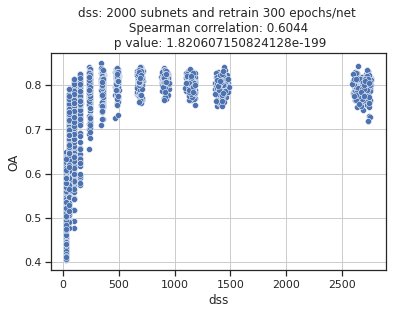

OA        7.993000e-01
m_size    2.585738e+07
Name: 285, dtype: float64


In [6]:
# dss with sign
plot_result_single(indian, 'dss')

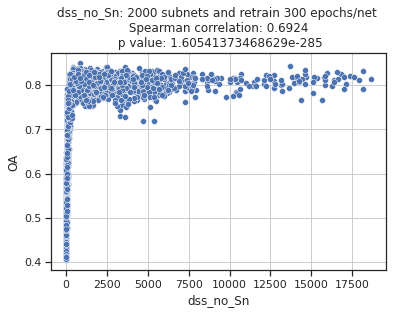

OA        8.136000e-01
m_size    2.682794e+07
Name: 1171, dtype: float64


In [7]:
## dss without sign
plot_result_single(indian, 'dss_no_Sn')

In [9]:
indian.columns

Index(['layer_num', 'embed_dim', 'num_heads', 'mlp_ratio', 'dss', 'OA',
       'flops', 'grasp', 'snip', 'zico', 'grad_norm', 'fisher', 'synflow',
       'jacob_cov', 'zico_modified', 'zico_act', 't_cet', 'NASWOT', 'croze',
       'm_size', 'logsynflow', 'embed_dim_s', 'head_dim', 'mean_head_dim',
       'sum_head_dim', 'mean_mlp_dim', 'sum_mlp_dim', 'mean_num_heads',
       'mean_mlp_ratio', 'sum_num_heads', 'sum_mlp_ratio', 'synflow_no_Sn',
       'logsynflow_no_Sn', 'dss_no_Sn', 'm_size_bin'],
      dtype='object')

In [10]:
# if 'zico_f' not in indian.columns:
#     zico_f = pd.read_csv('../TF-TAS/OUTPUT-indian/search2000/new_setup/test/search_results_zico_act_decay.csv').rename(columns={'zico_act': 'zico_f'})
#     indian = pd.merge(indian, zico_f[['mlp_ratio', 'num_heads', 'embed_dim', 'layer_num', 'zico_f']], on=merge_on)
if 'zico++' not in indian.columns:
    zico_f = pd.read_csv('../TF-TAS/OUTPUT-indian/search2000/new_setup/test/search_results_zico_act_decay.csv').rename(columns={'zico_act': 'zico++'})
    indian = pd.merge(indian, zico_f[['mlp_ratio', 'num_heads', 'embed_dim', 'layer_num', 'zico++']], on=merge_on)

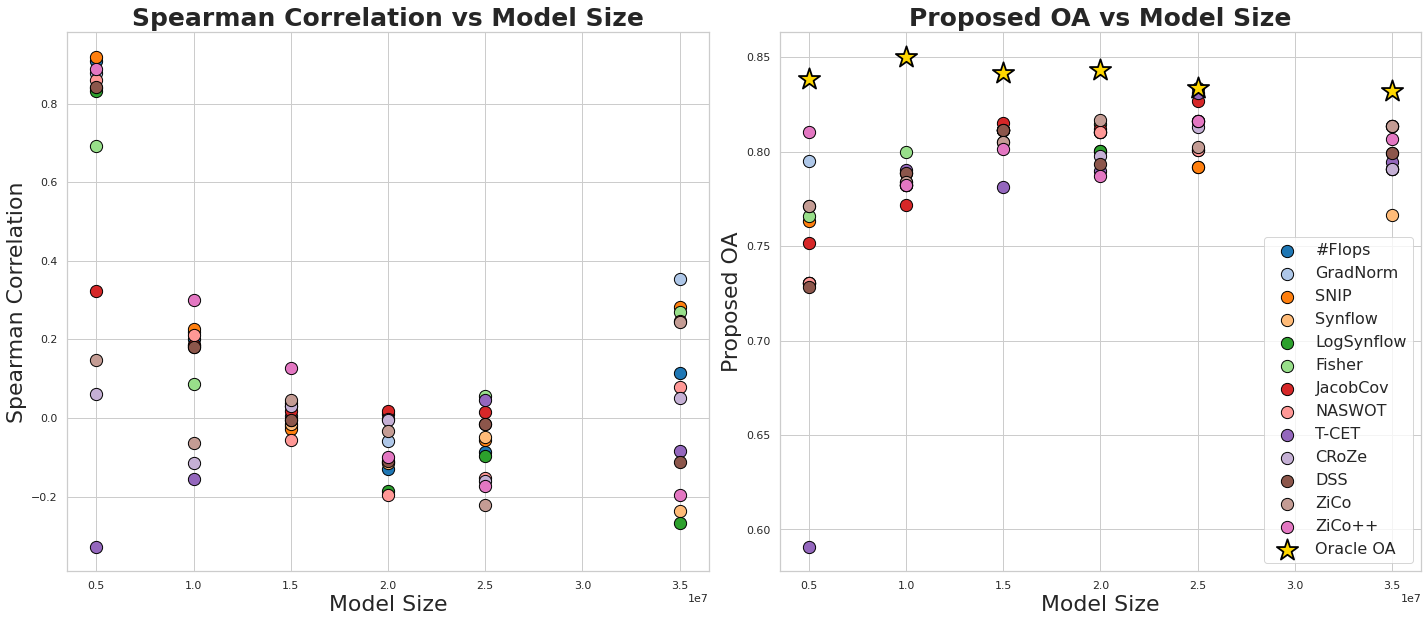

In [12]:
## plot results for different model size constraints
def plot_result_bins(data, inds, inds_n, save_fig=False):
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(1, 2, figsize=(20, 8.8), facecolor='white')
    
    # threshold_msize = [0, 0.5e7, 1e7, 1.5e7, 4e7]
    threshold_msize = [0, 0.5e7, 1e7, 1.5e7, 2e7, 2.5e7, 3.5e7]
    # threshold_msize = [0, 0.3e7, 0.6e7, 1e7, 1.5e7, 2e7, 4e7]
    # threshold_msize = [0, 0.3e7, 0.6e7, 0.9e7, 1.2e7, 1.5e7, 1.8e7, 2.1e7, 2.4e7, 4e7]

    data['m_size_bin'] = pd.cut(data['m_size'], bins=threshold_msize)
    grouped_df = data.groupby('m_size_bin')
    
    # Define colors and markers for each line plot
    # colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    # colors2 = sns.color_palette("husl", len(inds))
    # colors1 = sns.color_palette("tab10", len(inds)-3)
    colors = sns.color_palette("tab20", len(inds))
    # colors = colors1[:len(inds)] + colors2[-3:]
    # print(colors1, colors2)
    # colors = colors1[:len(inds)-2] + ['c', 'm']
    markers = ['o', 'v', '^', '<', '>', 's', 'p']
    
    for i, (ind, inds_n) in enumerate(zip(inds, inds_n)):
        sps = []
        oas = []

        for _, group in grouped_df:
            sps.append(stats.spearmanr(group[ind], group['OA'])[0])
            oas.append(group[group[ind] == max(group[ind])]['OA'].iloc[0])

        # Plot Spearman correlation
        if ind != 'OA':
            # sns.scatterplot(x=threshold_msize[1:], y=sps, marker='o', ax=ax[0], s=150, color=colors[i % len(colors)], edgecolor='black')
            sns.scatterplot(x=threshold_msize[1:], y=sps, marker='o', ax=ax[0], s=150, color=colors[i], edgecolor='black')
            ax[0].set_xlabel('Model Size', fontsize=22)
            ax[0].set_ylabel('Spearman Correlation', fontsize=22)
            ax[0].set_title('Spearman Correlation vs Model Size', fontsize=25, fontweight='bold')

        # Plot Best OA
        if ind == 'OA':
            sns.scatterplot(x=threshold_msize[1:], y=oas, marker='*', label='Oracle OA', ax=ax[1], s=500, color='gold', edgecolor='black')
        else:
            # sns.scatterplot(x=threshold_msize[1:], y=oas, marker='o', label=ind, ax=ax[1], s=150, color=colors[i % len(colors)], edgecolor='black')
            sns.scatterplot(x=threshold_msize[1:], y=oas, marker='o', label=inds_n, ax=ax[1], s=150, color=colors[i], edgecolor='black')

        ax[1].set_xlabel('Model Size', fontsize=22)
        ax[1].set_ylabel('Proposed OA', fontsize=22)
        ax[1].set_title('Proposed OA vs Model Size', fontsize=25, fontweight='bold')

    plt.legend(loc='lower right', fontsize=16)
    plt.tight_layout()
    plt.show()
    if save_fig:
        fig.savefig('model_sizes_3.pdf', format='pdf')
        
# Define the indicators to plot
inds = ['flops', 'grad_norm', 'snip', 'synflow','logsynflow', 'fisher', 'jacob_cov', 'NASWOT', 't_cet', 'croze', 'dss', 'zico', 'zico++', 'OA']
inds_n = ['#Flops', 'GradNorm', 'SNIP', 'Synflow','LogSynflow', 'Fisher', 'JacobCov', 'NASWOT', 'T-CET', 'CRoZe', 'DSS', 'ZiCo', 'ZiCo++', 'Oracle OA']

# Call the function to plot the data
plot_result_bins(indian, inds, inds_n, save_fig=True)

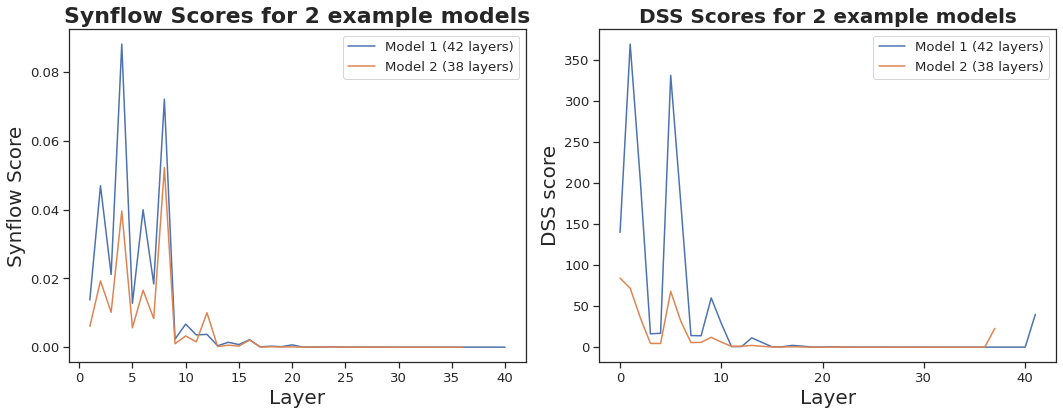

In [46]:
def plot_layer_scores():
    # Read Synflow scores
    with open('./results/layer_scores_synflow.txt', 'r') as file:
        lines = file.readlines()
    read_list_synflow = [list(map(float, line.strip().split(','))) for line in lines]
    
    # Read DSS scores
    with open('./results/layer_scores_dss.txt', 'r') as file:
        lines = file.readlines()
    read_list_dss = [list(map(float, line.strip().split(','))) for line in lines]
    
    # Set up figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot Synflow scores
    ax1 = axes[0]
    ax1.plot(range(1,len(read_list_synflow[0])-1),read_list_synflow[0][1:-1], label='Model 1 (42 layers)')
    ax1.plot(range(1,len(read_list_synflow[2])-1), read_list_synflow[2][1:-1], label='Model 2 (38 layers)')
    ax1.set_xlabel('Layer', fontsize=20)
    ax1.set_ylabel('Synflow Score', fontsize=20)
    ax1.set_title('Synflow Scores for 2 example models', fontsize=22, fontweight='bold')
    ax1.legend()
    
    # Plot DSS scores
    ax2 = axes[1]
    ax2.plot(read_list_dss[0], label='Model 1 (42 layers)')
    ax2.plot(read_list_dss[2], label='Model 2 (38 layers)')
    ax2.set_xlabel('Layer', fontsize=20)
    ax2.set_ylabel('DSS score', fontsize=20)
    ax2.set_title('DSS Scores for 2 example models', fontsize=20, fontweight='bold')
    ax2.legend()
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig('./layer_scores.pdf', format='pdf', bbox_inches='tight')
    plt.show()

plot_layer_scores()

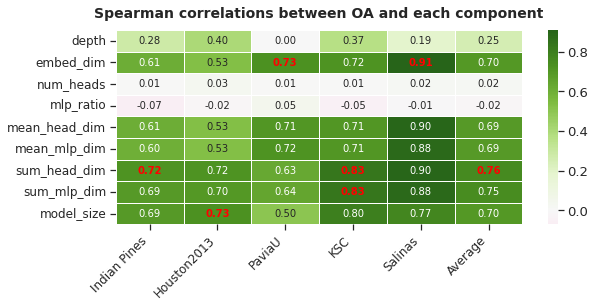

In [44]:
## plot the correlation between OA and each component
def plot_factor_oa_hm():
    data = {
        'Components': ['depth', 'embed_dim', 'num_heads', 'mlp_ratio', 'mean_head_dim', 'mean_mlp_dim', 'sum_head_dim', 'sum_mlp_dim', 'model_size'],
        'Indian Pines': [0.28, 0.61, 0.01, -0.07, 0.61, 0.60, 0.72, 0.69, 0.69],
        'Houston2013': [0.40, 0.53, 0.03, -0.02, 0.53, 0.53, 0.72, 0.70, 0.73],
        'PaviaU': [0.00, 0.73, 0.01, 0.05, 0.71, 0.72, 0.63, 0.64, 0.50],
        'KSC': [0.37, 0.72, 0.01, -0.05, 0.71, 0.71, 0.83, 0.83, 0.80],
        'Salinas': [0.19, 0.91, 0.02, -0.01, 0.90, 0.88, 0.90, 0.88, 0.77]
    }
    df = pd.DataFrame(data)
    m = []
    for i in range(len(df)):
        m.append(np.mean(df.iloc[i][1:]))
    df['Average'] = m
    df.set_index('Components', inplace=True)
    
    plt.figure(figsize=(9, 4.5))
    ax = sns.heatmap(df, cmap='PiYG', center=0, annot=True, fmt=".2f", linewidths=.5)
    
    # Annotate each cell
    for i, text in enumerate(ax.texts):
        text.set_size(10)
        for j in range(6):
            if i % 6 == j and text.get_text() in [str(round(df.max().values[j], 2)), '1.00']:
                text.set_color('red')
                text.set_weight('bold')
                break
    
    plt.title('Spearman correlations between OA and each component', fontsize=14, fontweight='bold', pad=12)
    plt.xticks(fontsize=12, rotation=45, ha='right')
    plt.yticks(fontsize=12, rotation=0)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.savefig('factor_oa_hm.pdf', format='pdf')
    plt.show()

plot_factor_oa_hm()

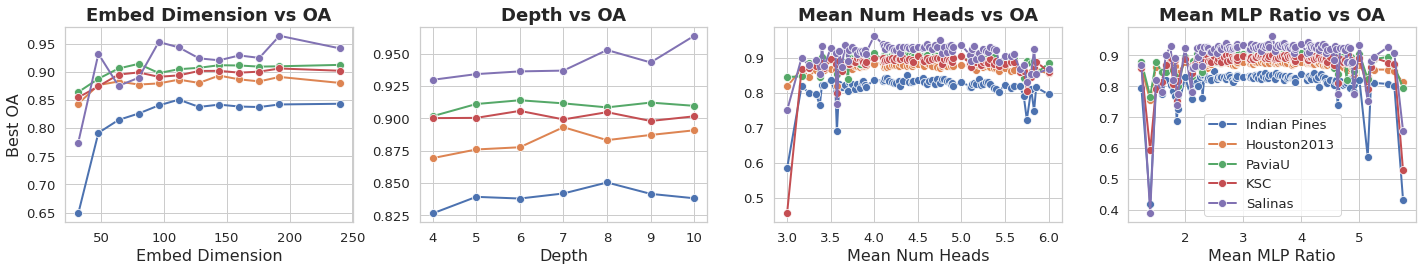

In [20]:
## plot optimal OA of each component
def get_factor_ind(data, ind='OA'):
    data['num_heads_l'] = data['num_heads'].apply(eval).tolist()
    data['num_heads_mean'] = [np.mean(i) for i in data['num_heads_l']]
    data['mlp_ratio_l'] = data['mlp_ratio'].apply(eval).tolist()
    data['mean_mlp_ratio'] = [np.mean(i) for i in data['mlp_ratio_l']]

    embs = np.unique(data['embed_dim_s'].values)
    layers = np.unique(data['layer_num'].values)
    mean_heads = np.unique(data['num_heads_mean'].values)
    mean_mlp_ratio = np.unique(data['mean_mlp_ratio'].values)

    max_oas_emb = [data.loc[data['embed_dim_s'] == emb].nlargest(1, ind)[ind].values[0] for emb in embs]
    max_oas_layer = [data.loc[data['layer_num'] == layer].nlargest(1, ind)[ind].values[0] for layer in layers]
    max_oas_heads = [data.loc[data['num_heads_mean'] == head].nlargest(1, ind)[ind].values[0] for head in mean_heads]
    max_oas_mlp_ratio = [data.loc[data['mean_mlp_ratio'] == mlp_ratio].nlargest(1, ind)[ind].values[0] for mlp_ratio in mean_mlp_ratio]
    data.drop(columns=['num_heads_l', 'mlp_ratio_l'])
    return max_oas_emb, max_oas_layer, max_oas_heads, max_oas_mlp_ratio, embs, layers, mean_heads, mean_mlp_ratio

def plot_factor_OA_all(ind='OA', save_fig=False):
    sns.set(style="whitegrid", font_scale=1.2)
    fig, ax = plt.subplots(1, 4, figsize=(20, 4))

    datasets = [indian, houston, pavia, ksc, salinas]
    labels = ['Indian Pines', 'Houston2013', 'PaviaU', 'KSC', 'Salinas']

    for data, label in zip(datasets, labels):
        max_oas_emb, max_oas_layer, max_oas_heads, max_oas_mlp_ratio, embs, layers, mean_heads, mean_mlp_ratio = get_factor_ind(data, ind)

        sns.lineplot(x=embs, y=max_oas_emb, marker='o', ax=ax[0], palette="viridis", markersize=8, linewidth=2)
        ax[0].set_xlabel('Embed Dimension', fontsize=16)
        ax[0].set_ylabel('Best OA', fontsize=16)
        ax[0].set_title('Embed Dimension vs OA', fontsize=18, fontweight='bold')

        sns.lineplot(x=layers, y=max_oas_layer, marker='o', ax=ax[1], palette="viridis", markersize=8, linewidth=2)
        ax[1].set_xlabel('Depth', fontsize=16)
        ax[1].set_title('Depth vs OA', fontsize=18, fontweight='bold')

        sns.lineplot(x=mean_heads, y=max_oas_heads, marker='o', ax=ax[2], palette="viridis", markersize=8, linewidth=2)
        ax[2].set_xlabel('Mean Num Heads', fontsize=16)
        ax[2].set_title('Mean Num Heads vs OA', fontsize=18, fontweight='bold')

        sns.lineplot(x=mean_mlp_ratio, y=max_oas_mlp_ratio, marker='o', ax=ax[3], label=label, palette="viridis", markersize=8, linewidth=2)
        ax[3].set_xlabel('Mean MLP Ratio', fontsize=16)
        ax[3].set_title('Mean MLP Ratio vs OA', fontsize=18, fontweight='bold')
        ax[3].legend(loc='lower center')

    plt.tight_layout()
    if save_fig:
        fig.savefig('factor_oa_all.pdf', format='pdf', bbox_inches='tight')
    plt.show()

plot_factor_OA_all('OA', save_fig=True)


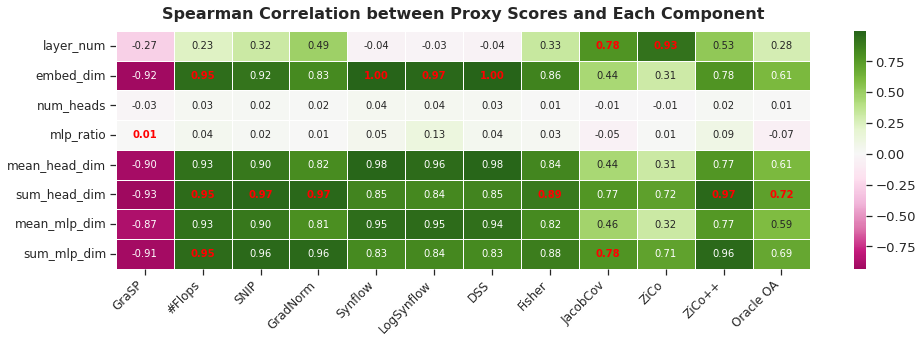

In [45]:
## plot correlation between proxies and each component
def plot_all_factors_hm(data, save_fig=False):
    # inds = ['grasp', 'flops', 'snip', 'grad_norm', 'synflow', 'logsynflow', 'dss', 'fisher', 'jacob_cov',  'zico', 'zico_modified', 'zico_act', 'Oracle_OA']
    inds = ['grasp', 'flops', 'snip', 'grad_norm', 'synflow', 'logsynflow', 'dss', 'fisher', 'jacob_cov',  'zico', 'zico++', 'Oracle_OA']
    inds_n = ['GraSP', '#Flops', 'SNIP', 'GradNorm', 'Synflow','LogSynflow', 'DSS', 'Fisher', 'JacobCov', 'ZiCo', 'ZiCo++', 'Oracle OA']
    factors = ['layer_num', 'embed_dim', 'num_heads', 'mlp_ratio', 'mean_head_dim', 'sum_head_dim', 'mean_mlp_dim', 'sum_mlp_dim']
    corrs = {factor: get_corrs_factors(data, inds, factor) for factor in factors}

    # Create a DataFrame from the correlations
    df = pd.DataFrame(corrs, index=inds).T

    # Create a heatmap
    plt.figure(figsize=(14, 5))
    ax = sns.heatmap(df, annot=True, cmap='PiYG', center=0, fmt=".2f", linewidths=.5, xticklabels=inds_n)
    
    # Annotate cells with max correlation or perfect correlation
    for i, text in enumerate(ax.texts):
        text.set_size(10)
        for j in range(len(inds)):
            if i % len(inds) == j and text.get_text() in [str(round(df.max().values[j], 2)), '1.00']:
                text.set_color('red')
                text.set_weight('bold')
                break
            
    plt.title('Spearman Correlation between Proxy Scores and Each Component', fontsize=16, fontweight='bold', pad=12)
    # plt.xlabel('Proxy', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    # plt.ylabel('Component', fontsize=14)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    if save_fig:
        plt.savefig('factors_sp2_hm.pdf', format='pdf')
    plt.show()

plot_all_factors_hm(indian, save_fig=True)

In [48]:
## add MSA and MLP scores
indian = add_decomp('./outputs/indian/', indian, 'dss', 'mlp')
indian = add_decomp('./outputs/indian/', indian, 'dss', 'msa')
indian = add_decomp('./outputs/indian/', indian, 'synflow', 'mlp')
indian = add_decomp('./outputs/indian/', indian, 'synflow', 'msa')
indian = add_decomp('./outputs/indian/', indian, 'snip', 'mlp')
indian = add_decomp('./outputs/indian/', indian, 'snip', 'msa')

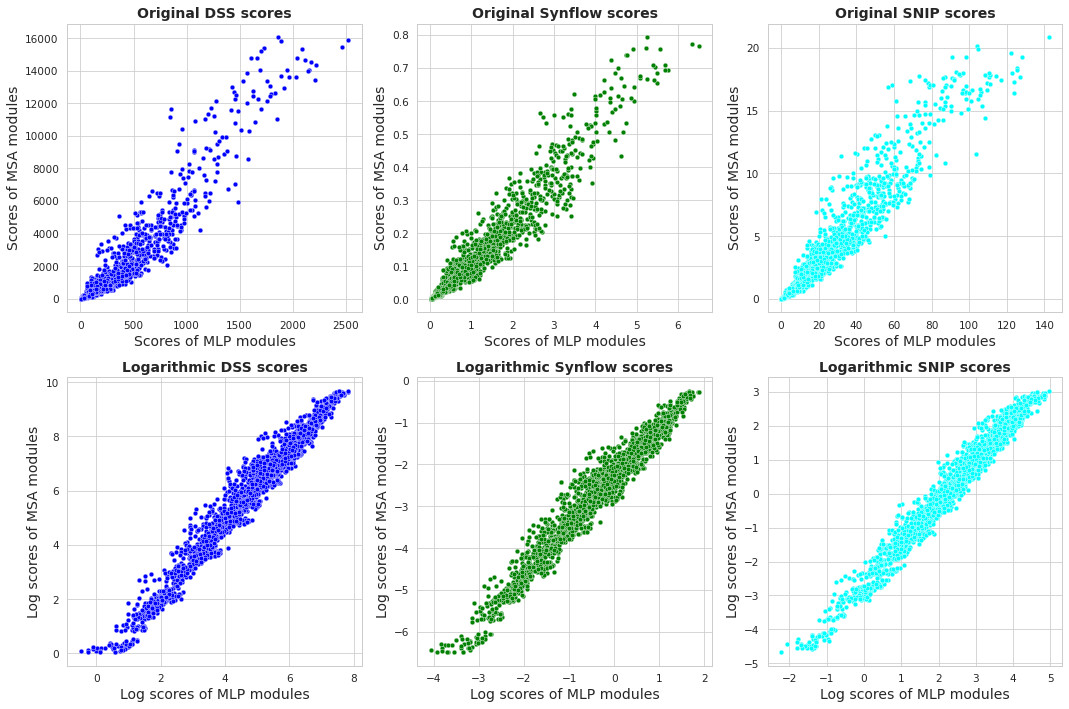

In [57]:
def plot_mlp_msa(data):
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.2)
    
    # Create a single figure with two rows
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Define dot colors for each column
    dot_colors = ['blue', 'green', 'cyan']
    
    # DSS Scores
    sns.scatterplot(x=data['dss_mlp'], y=data['dss_msa'], color=dot_colors[0], ax=axes[0, 0])
    axes[0, 0].set_xlabel('Scores of MLP modules', fontsize=14)
    axes[0, 0].set_ylabel('Scores of MSA modules', fontsize=14)
    axes[0, 0].set_title('Original DSS scores', fontsize=14, fontweight='bold')
    
    # Synflow Scores
    sns.scatterplot(x=data['synflow_mlp'], y=data['synflow_msa'], color=dot_colors[1], ax=axes[0, 1])
    axes[0, 1].set_xlabel('Scores of MLP modules', fontsize=14)
    axes[0, 1].set_ylabel('Scores of MSA modules', fontsize=14)
    axes[0, 1].set_title('Original Synflow scores', fontsize=14, fontweight='bold')
    
    # SNIP Scores
    sns.scatterplot(x=data['snip_mlp'], y=data['snip_msa'], color=dot_colors[2], ax=axes[0, 2])
    axes[0, 2].set_xlabel('Scores of MLP modules', fontsize=14)
    axes[0, 2].set_ylabel('Scores of MSA modules', fontsize=14)
    axes[0, 2].set_title('Original SNIP scores', fontsize=14, fontweight='bold')
    
    # DSS Scores (log-transformed)
    sns.scatterplot(x=np.log(data['dss_mlp']), y=np.log(data['dss_msa']), color=dot_colors[0], ax=axes[1, 0])
    axes[1, 0].set_xlabel('Log scores of MLP modules', fontsize=14)
    axes[1, 0].set_ylabel('Log scores of MSA modules', fontsize=14)
    axes[1, 0].set_title('Logarithmic DSS scores', fontsize=14, fontweight='bold')
    
    # Synflow Scores (log-transformed)
    sns.scatterplot(x=np.log(data['synflow_mlp']), y=np.log(data['synflow_msa']), color=dot_colors[1], ax=axes[1, 1])
    axes[1, 1].set_xlabel('Log scores of MLP modules', fontsize=14)
    axes[1, 1].set_ylabel('Log scores of MSA modules', fontsize=14)
    axes[1, 1].set_title('Logarithmic Synflow scores', fontsize=14, fontweight='bold')
    
    # SNIP Scores (log-transformed)
    sns.scatterplot(x=np.log(data['snip_mlp']), y=np.log(data['snip_msa']), color=dot_colors[2], ax=axes[1, 2])
    axes[1, 2].set_xlabel('Log scores of MLP modules', fontsize=14)
    axes[1, 2].set_ylabel('Log scores of MSA modules', fontsize=14)
    axes[1, 2].set_title('Logarithmic SNIP scores', fontsize=14, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig('mlp_msa_all.pdf', format='pdf', bbox_inches='tight')
    plt.show()

plot_mlp_msa(indian)


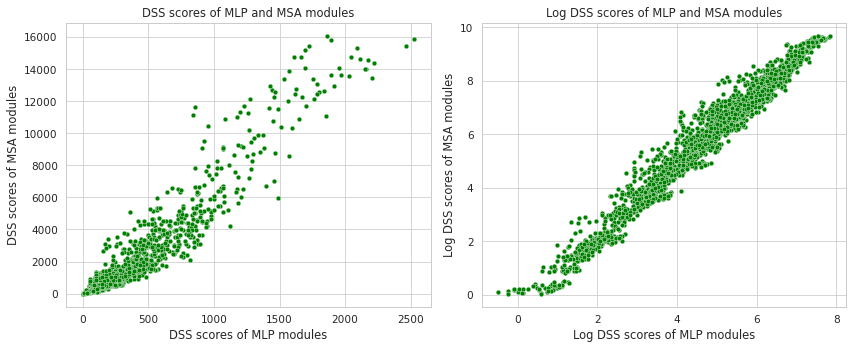

In [108]:
def plot_mlp_msa_dss(data):
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.2)
    
    # Create a single figure with two rows
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Define dot colors for each column
    dot_colors = ['blue', 'green', 'cyan']
    
    # DSS Scores
    sns.scatterplot(x=data['dss_mlp'], y=data['dss_msa'], color=dot_colors[1], ax=axes[0])
    axes[0].set_xlabel('DSS scores of MLP modules')
    axes[0].set_ylabel('DSS scores of MSA modules')
    axes[0].set_title('DSS scores of MLP and MSA modules')
    
    # DSS Scores (log-transformed)
    sns.scatterplot(x=np.log(data['dss_mlp']), y=np.log(data['dss_msa']), color=dot_colors[1], ax=axes[1])
    axes[1].set_xlabel('Log DSS scores of MLP modules')
    axes[1].set_ylabel('Log DSS scores of MSA modules')
    axes[1].set_title('Log DSS scores of MLP and MSA modules')
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig('mlp_msa_dss.pdf', format='pdf', bbox_inches='tight')
    plt.show()

plot_mlp_msa_dss(indian)

In [116]:
print(np.mean(indian['synflow_no_Sn_mlp'].values), np.std(indian['synflow_mlp'].values), np.mean(indian['synflow_msa'].values), np.std(indian['synflow_msa'].values))
print(np.mean(np.log(indian['synflow_mlp'])), np.std(np.log(indian['synflow_mlp'])), np.mean(np.log(indian['synflow_msa'])), np.std(np.log(indian['synflow_msa'])))

1.0601478439681669 1.0792754244813207 0.12335367854041214 0.1420932489021665
-0.4898080694873623 1.1447054654833748 -2.8131417166073733 1.3573063429389831


RQ4: Train with a Randomforest model to predict submodels' performance

In [27]:
## Train with machine learning models
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer

def build_pipeline_reg(regressor, scaling=False):
    num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
    if scaling:
        num_pipe.steps.insert(1,["scaler", StandardScaler()])
    transform = ColumnTransformer(transformers=[('num', num_pipe, slice(0, -1))])
    return Pipeline(steps=[('preprocess', transform), ('reg', regressor)])

def build_pipeline(regressor, categorical, scaling=False):
    cat_pipe = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
    num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
    if scaling:
        num_pipe.steps.insert(1,["scaler", StandardScaler()])
    transform = make_column_transformer((cat_pipe, categorical), remainder=num_pipe)
    return Pipeline(steps=[('preprocess', transform), ('reg', regressor)])

categorical = ['layer_num', 'embed_dim', 'num_heads', 'mlp_ratio']
# categorical = ['layer_num', 'embed_dim', 'num_heads', 'mlp_ratio', 'archs']
# categorical = ['archs']

In [28]:
def ml_train(model, X, y):
  random_states = [0, 1, 42, 1000, 65535]
  train_size = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.5]
  r2_s = []
  sps = []
  oas = []
  ms = []
  drop_clm = ['OA', 'm_size']
  for ts in train_size:
    for rs in random_states:
      X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=ts, random_state=rs, shuffle=True)
      model.fit(X_train.drop(columns=drop_clm), y_train)
      X_test['pred_oa'] = model.predict(X_test.drop(columns=drop_clm))
      r2_s.append(r2_score(y_test, X_test['pred_oa']))
      sps.append(stats.spearmanr(X_test['OA'], X_test['pred_oa'])[0])
      oas.append(X_test[X_test['pred_oa'] == max(X_test['pred_oa'])]['OA'].iloc[0])
      ms.append(X_test[X_test['pred_oa'] == max(X_test['pred_oa'])]['m_size'].iloc[0])
  r2_s = np.array(r2_s).reshape((7, -1))
  sps = np.array(sps).reshape((7, -1))
  oas = np.array(oas).reshape((7, -1))
  ms = np.array(ms).reshape((7, -1))
  return r2_s, sps, oas, ms

In [29]:
Xs = indian[['layer_num', 'embed_dim', 'num_heads', 'mlp_ratio', 'dss', 'OA','snip', 'zico', 'grad_norm', 'fisher', 'synflow', 'm_size']]
y = Xs[['OA']].values.reshape(-1)

In [30]:
drop_clm = ['OA']
# regressor_ip = LinearRegression()
regressor_ip = RandomForestRegressor()
pipe_ip = build_pipeline(regressor_ip,categorical, scaling=True)

In [31]:
Xs0 = indian[['layer_num', 'embed_dim', 'num_heads', 'mlp_ratio', 'm_size', 'OA']]
r2_s0, sps0, oas0, ms0 = ml_train(pipe_ip, Xs0, y)

In [32]:
r2_s, sps, oas, ms = ml_train(pipe_ip, Xs, y)

In [33]:
train_size = [0.0, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.5]
sps0 = np.vstack((np.array([0.71,0.71,0.71,0.71,0.71]), sps0))
sps = np.vstack((np.array([0.71,0.71,0.71,0.71,0.71]), sps))

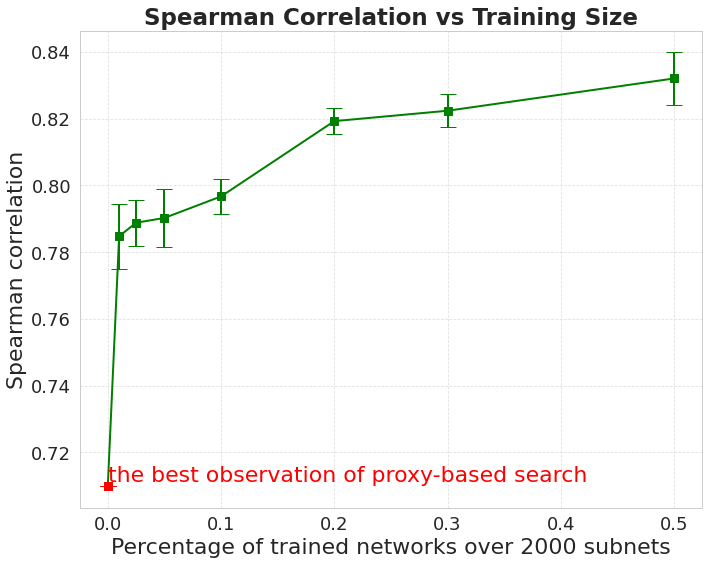

In [60]:
plt.figure(figsize=(10, 8))  # Increase figure size

# Plot the data
plt.errorbar(train_size, np.mean(sps, axis=1), yerr=np.std(sps, axis=1), marker='s', markersize=8, capsize=8, color='green', linestyle='-', linewidth=2)  # Use a different marker style

# Highlight the first point with a different color
plt.errorbar(train_size[0], np.mean(sps[0]), yerr=np.std(sps[0]), marker='s', markersize=8, capsize=8, color='red', linestyle='-', linewidth=2) 

# Add text next to the highlighted point
plt.text(train_size[0], np.mean(sps[0]), f'the best observation of proxy-based search', verticalalignment='bottom', horizontalalignment='left', fontsize=22, color='red')

# Customize plot properties
plt.xlabel('Percentage of trained networks over 2000 subnets', fontsize=22)  # Increase font size
plt.ylabel('Spearman correlation', fontsize=22)  # Increase font size
plt.title('Spearman Correlation vs Training Size', fontsize=23, fontweight='bold')  # Increase font size and add a descriptive title
plt.xticks(fontsize=18)  # Adjust font size
plt.yticks(fontsize=18)  # Adjust font size
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('sp_pred_oa.pdf', format='pdf')
plt.show()

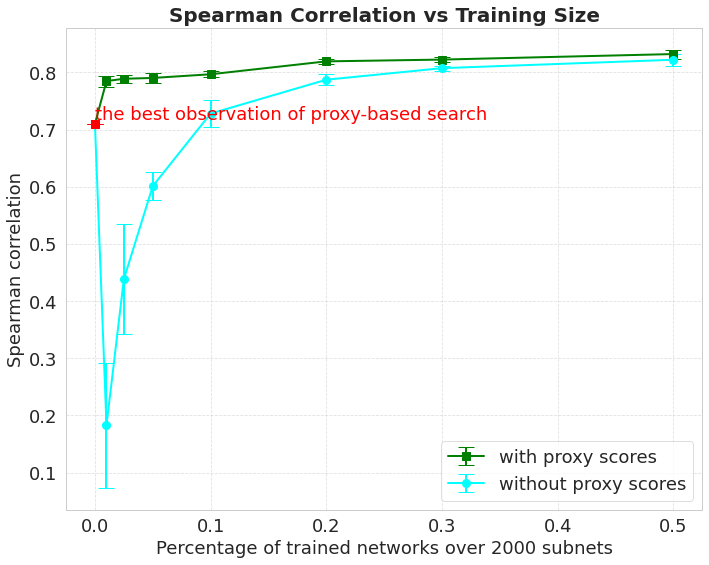

In [61]:
plt.figure(figsize=(10, 8))  # Increase figure size

# Plot the data
plt.errorbar(train_size, np.mean(sps, axis=1), yerr=np.std(sps, axis=1), marker='s', markersize=8, capsize=8, color='green', linestyle='-', linewidth=2, label='with proxy scores')  # Use a different marker style

# plt.errorbar(train_size, np.mean(sps1, axis=1), yerr=np.std(sps1, axis=1), label='0', marker='o', capsize=5, color='cyan', ecolor='red')
plt.errorbar(train_size, np.mean(sps0, axis=1), yerr=np.std(sps0, axis=1), marker='o', markersize=8, capsize=8, color='cyan', linestyle='-', linewidth=2, label='without proxy scores')  # Increase marker size, thickness of error bars

# Highlight the first point with a different color
plt.errorbar(train_size[0], np.mean(sps[0]), yerr=np.std(sps[0]), marker='s', markersize=8, capsize=8, color='red', linestyle='-', linewidth=2) 

# Add text next to the highlighted point
plt.text(train_size[0], np.mean(sps[0]), f'the best observation of proxy-based search', verticalalignment='bottom', horizontalalignment='left', fontsize=18, color='red')

# Customize plot properties
plt.xlabel('Percentage of trained networks over 2000 subnets', fontsize=18)  # Increase font size
plt.ylabel('Spearman correlation', fontsize=18)  # Increase font size
plt.title('Spearman Correlation vs Training Size', fontsize=20, fontweight='bold')  # Increase font size and add a descriptive title
plt.xticks(fontsize=18)  # Adjust font size
plt.yticks(fontsize=18)  # Adjust font size
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=18)  # Increase font size of legend
plt.tight_layout()
plt.savefig('sp_pred_oa_2.pdf', format='pdf')
plt.show()

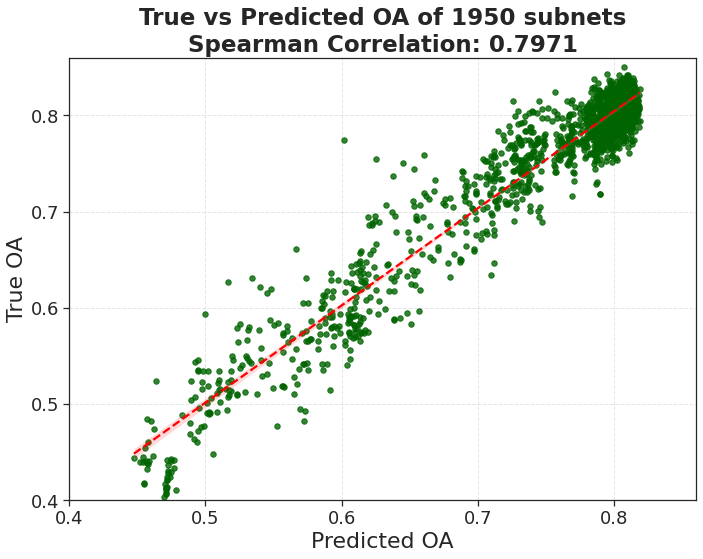

In [39]:
X_train, X_test, y_train, y_test = train_test_split(Xs,y, train_size=0.025, random_state=65535, shuffle=True)
pipe_ip.fit(X_train.drop(columns=drop_clm), y_train)
X_test['Predicted_OA'] = pipe_ip.predict(X_test.drop(columns=drop_clm))
print(r2_score(y_test, X_test['Predicted_OA']))
# plot_result_single(X_test, 'Predicted_OA')

sns.set(style="ticks", font_scale=1.2)
corr = stats.spearmanr(X_test['OA'], X_test['Predicted_OA'])[0]

plt.figure(figsize=(10, 8))  # Adjust the size as needed
sns.regplot(x=X_test['Predicted_OA'], y=X_test['OA'], scatter_kws={'s': 30}, color='darkgreen', line_kws={'color': 'red', 'linestyle': '--'})  # Increase scatter point size, add a diagonal line
plt.title(f'True vs Predicted OA of 1950 subnets\nSpearman Correlation: {corr:.4f}', fontsize=23, fontweight='bold')  
plt.xlabel('Predicted OA', fontsize=22)  # Adjust font size
plt.ylabel('True OA', fontsize=22)  # Adjust font size
plt.xticks(fontsize=18)  # Adjust font size
plt.yticks(fontsize=18)  # Adjust font size
plt.xlim(0.4, 0.86)  # Set symmetrical x-axis limits
plt.ylim(0.4, 0.86)  # Set symmetrical y-axis limits
plt.grid(True, linestyle='--', alpha=0.5)  # Adjust grid style and transparency
plt.tight_layout()
plt.savefig('true_vs_pred_oa.pdf', format='pdf')
# Save or display the plot
plt.show()


Data Independence - proxies

In [21]:
a = indian[['layer_num', 'embed_dim', 'num_heads', 'mlp_ratio', 'm_size', 'OA', 'snip', 'grad_norm']][:1999].copy()
a.rename(columns={'m_size':'m_size_ip', 'OA':'OA_ip', 'snip':'snip_ip', 'grad_norm':'grad_norm_ip'}, inplace=True)
b = pavia[['layer_num', 'embed_dim', 'num_heads', 'mlp_ratio','m_size', 'OA', 'snip', 'grad_norm']]
a = pd.merge(a, b, on=merge_on)

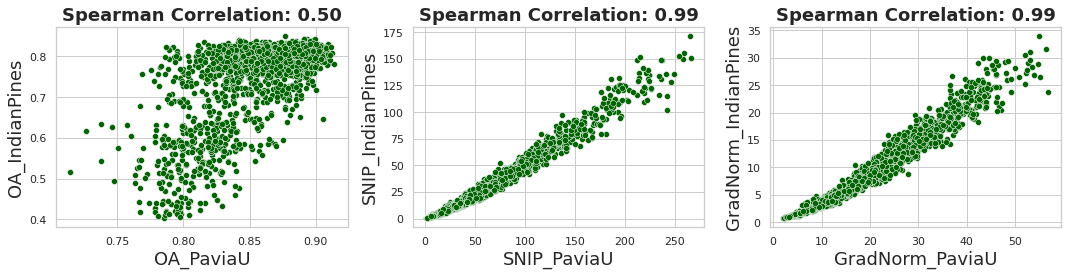

In [25]:
# Set the style to seaborn
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Plot the first scatter plot on the first subplot
sns.scatterplot(data=a, x='OA', y='OA_ip', ax=axs[0], color='darkgreen')
axs[0].set_title(f"Spearman Correlation: {stats.spearmanr(a['OA'], a['OA_ip'])[0]:.2f}", fontsize=18, fontweight='bold')
axs[0].set_xlabel('OA_PaviaU', fontsize=18)
axs[0].set_ylabel('OA_IndianPines', fontsize=18)

# Plot the second scatter plot on the second subplot
sns.scatterplot(data=a, x='snip', y='snip_ip', ax=axs[1], color='darkgreen')
axs[1].set_title(f"Spearman Correlation: {stats.spearmanr(a['snip'], a['snip_ip'])[0]:.2f}", fontsize=18, fontweight='bold')
axs[1].set_xlabel('SNIP_PaviaU', fontsize=18)
axs[1].set_ylabel('SNIP_IndianPines', fontsize=18)

# Plot the third scatter plot on the third subplot
sns.scatterplot(data=a, x='grad_norm', y='grad_norm_ip', ax=axs[2], color='darkgreen')
axs[2].set_title(f"Spearman Correlation: {stats.spearmanr(a['grad_norm'], a['grad_norm_ip'])[0]:.2f}", fontsize=18, fontweight='bold')
axs[2].set_xlabel('GradNorm_PaviaU', fontsize=18)
axs[2].set_ylabel('GradNorm_IndianPines', fontsize=18)

plt.tight_layout()
plt.savefig('data_dep.pdf', format='pdf')
plt.show()